# Оптимизация маркетинговых  расходов Яндекс.Афиша

**Заказчик** — Яндекс.Афиша, отдел маркетинга.

**Цель исследования** - для корректировки рекламного бюджета Яндекс.Афиша необходимо провести анализ поведения клиентов, первой покупки и прибыльности клиента, отказаться от невыгодных источников трафика, дать рекомендации о перераспределении бюджета.

**Исходные данные** — данные Яндекс.Афиши с июня 2017 по конец мая 2018 года в таблицах Заказы, Посещения и Расходы.


## Изучение и предобработка вводных данных

Загрузим исходные таблицы с данными Яндекс.Афиши.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns

# активируем настройку по отображению всех столбцов
pd.set_option('display.max_columns', None)

visits = pd.read_csv('visits_log.csv')
orders = pd.read_csv('orders_log.csv')
costs = pd.read_csv('costs.csv')

Теперь поочередно проверим их и проведем предобработку

### Visits

In [2]:
visits.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [3]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [4]:
visits.duplicated().sum()

0

Можем видеть, что в таблице 359400 строк, пустые значения отсутствуют, дубликатов нет, столбцы с датами содержат несоответствующие форматы.
Приведем форматы к типу datetime

In [5]:
visits['End Ts'] = visits['End Ts'].astype('datetime64')
visits['Start Ts'] = visits['Start Ts'].astype('datetime64')

### Orders

In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [7]:
orders.duplicated().sum()

0

Ситуация аналогична с таблицей Visits

In [8]:
orders['Buy Ts'] = orders['Buy Ts'].astype('datetime64')

### Costs

In [9]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [10]:
costs.duplicated().sum()

0

Дубликатов нет, пропусков тоже, преобразуем столбец dt к формату даты

In [11]:
costs['dt'] = costs['dt'].astype('datetime64')

### Наименования столбцов

В проверяемых таблицах замечены некорректные наименования столбцов, приведем их к нужному виду.

In [12]:
for df in [visits, orders, costs]:
    df.columns = df.columns.str.lower().str.replace(' ', '_')

## Расчет и анализ метрик

В представленных базах данных имеем 3 таблицы, к которым целесообразно применять различные методы анализа для получения ответов на поставленные вопросы. 
К таблице с посещениями сайта целесообразно применить Продуктовые метрики, проанализировать поведение пользователей, количество посещений и продолжительность сессий, определить наиболее популярные платформы, удержание аудитории.

В Orders имеем перечень заказов, из которых можно рассчитать средний чек, покупательскую активность, проследить изменения продаж во времени.

Данные по расходам необходимы для рассчтов эффективности затрат, прибыльности клиента, определим окупаемость инвестиций по видам источников привлечения клиентов. 


### Оценка пользовательской активности


Так как в работе будут применяться данные о продолжительности пользовательских сессий, важно проверить данные на корректность. Для этого определим, нет ли строк, где сессия имеет отрицательные значения равные нулю.

In [13]:
visits[(visits['end_ts'] - visits['start_ts']) <='0 sec']['end_ts'].count()

35796

Выходит, почти 10 процентов данных имеют ошибочные значения. Так как за 0 или менее секунд едва ли пользователь мог принять осознанное решение о приобретении услуг, не будем учитывать подобные строки при анализе.

In [14]:
visits_corr = visits[(visits['end_ts'] - visits['start_ts']) >'0 sec']

In [15]:
visits_corr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 323604 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   device     323604 non-null  object        
 1   end_ts     323604 non-null  datetime64[ns]
 2   source_id  323604 non-null  int64         
 3   start_ts   323604 non-null  datetime64[ns]
 4   uid        323604 non-null  uint64        
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 14.8+ MB


#### Уникальные пользователи

Начнем работу с информацией по посещаемости сайта Яндекс.Афиша. Рассчитаем показатели DAU, WAU и MAU в среднем за весь период и отследим изменения во времени.

Первым шагом выделим в отдельные столбцы год, месяц и неделю, а также полную дату.

In [16]:
visits_corr['ts_year']  = visits_corr['start_ts'].dt.year
visits_corr['ts_month'] = visits_corr['start_ts'].dt.month
visits_corr['ts_week']  = visits_corr['start_ts'].dt.week
visits_corr['ts_date'] = visits_corr['start_ts'].dt.date.astype('datetime64')

<ipython-input-16-9262cbda5281>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visits_corr['ts_year']  = visits_corr['start_ts'].dt.year
<ipython-input-16-9262cbda5281>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visits_corr['ts_month'] = visits_corr['start_ts'].dt.month
<ipython-input-16-9262cbda5281>:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  visits_corr['ts_week']  = visits_corr['start_ts'].dt.week
<ipython-in

Теперь сгруппируем и найдем метрики. Для нахождения WAU и MAU в динамике, каждому значению, помимо номера недели и месяца необходимо присвоить дату начала периода, чтобы наблюдать зависимость от даты.

In [17]:
visits_corr['week_date'] = visits_corr['ts_date'] - pd.to_timedelta(visits_corr['ts_date'].dt.dayofweek, unit = 'd')
visits_corr['month_date'] = visits_corr['ts_date'].astype('datetime64[M]')

dau = visits_corr.groupby('ts_date').agg({'uid': 'nunique'}).reset_index()
wau = visits_corr.groupby(['ts_year', 'ts_week']).agg({'uid': 'nunique','week_date': 'min'}).reset_index()
mau = visits_corr.groupby(['ts_year', 'ts_month']).agg({'uid': 'nunique', 'month_date': 'min'}).reset_index()

dau_total = dau['uid'].mean()
wau_total = wau['uid'].mean()
mau_total = mau['uid'].mean()


print('dau_mean:', int(dau_total))
print('mau_mean:', int(mau_total))
print('wau_mean:', int(wau_total))

<ipython-input-17-91abcffacbb1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visits_corr['week_date'] = visits_corr['ts_date'] - pd.to_timedelta(visits_corr['ts_date'].dt.dayofweek, unit = 'd')
<ipython-input-17-91abcffacbb1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visits_corr['month_date'] = visits_corr['ts_date'].astype('datetime64[M]')


dau_mean: 817
mau_mean: 20955
wau_mean: 5148


Средние значения метрик определены, посмотрим их в динамике

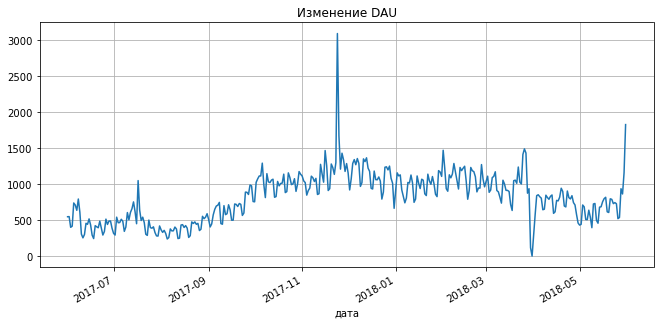

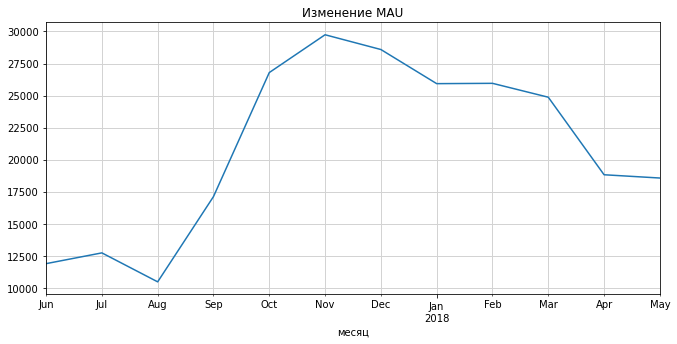

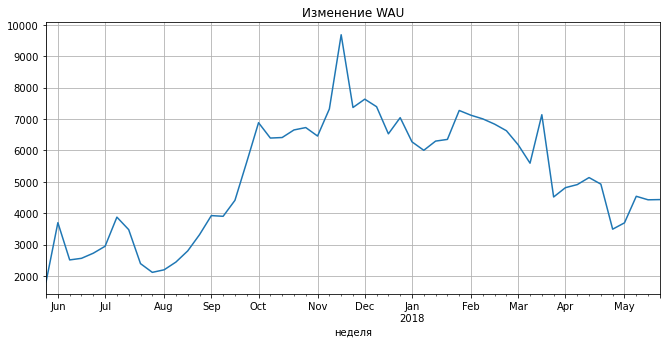

In [18]:
dau.plot(x = 'ts_date', y = 'uid', figsize = (11,5), grid = True)
plt.title('Изменение DAU')
plt.xlabel('дата')
plt.legend().remove()
plt.show()

mau.plot(x = 'month_date', y = 'uid', figsize = (11,5))
plt.title('Изменение MAU')
plt.xlabel('месяц')
plt.legend().remove()
plt.grid(which='major', color = 'lightgray', linewidth = 1)
plt.grid(which='minor', color = 'lightgray', linewidth = 1) 
plt.show()

wau.plot(x = 'week_date', y = 'uid', figsize = (11,5), grid = True)
plt.title('Изменение WAU')
plt.xlabel('неделя')
plt.legend().remove()
plt.show()


In [19]:
mau

,ts_year,ts_month,uid,month_date
0,2017,6,11885,2017-06-01
1,2017,7,12725,2017-07-01
2,2017,8,10465,2017-08-01
3,2017,9,17117,2017-09-01
4,2017,10,26794,2017-10-01
5,2017,11,29745,2017-11-01
6,2017,12,28593,2017-12-01
7,2018,1,25930,2018-01-01
8,2018,2,25955,2018-02-01
9,2018,3,24872,2018-03-01


Полученные графики метрик DAU, WAU и MAU имеют очень схожую структуру. Мы можем наблюдать относительно небольшое число уникальных пользователей летом, и значительный рост к новому году. Также, имеется всплеск в конце мая. Летом многие в отпусках, в связи с чем меньшее число клиентов посещает места развлечений и прибегает к услугам Яндекс.Афиша. Обратная картина под новый год, многие не работают и зимой проводят время дома, смотрят кино, ищут данные на Афише. Майский всплеск вероятнее всего отражает конец учебного сезона, школьники и студенты отмечают начало каникул, резко растет спрос на поиск мест развлечений. В среднем в течение года ресурс прирастает на 20 955 пользователей в месяц. Можно сделать вывод, популярность Яндекс.Афиши напрямую связана с сезонными особенностями в поведении людей. 

#### Активность седнестатистического пользователя

Теперь определим, сколько раз за день пользователи в среднем заходят на сайт. 

In [20]:
session_per_user = visits_corr.groupby('ts_date').agg({'uid' : ['count', 'nunique']}).reset_index()
session_per_user.columns = ['ts_date', 'n_sessions', 'n_users']
session_per_user['ses_per_user'] = session_per_user['n_sessions'] / session_per_user['n_users']
session_per_user

,ts_date,n_sessions,n_users,ses_per_user
0,2017-06-01,599,547,1.095064
1,2017-06-02,596,549,1.085610
2,2017-06-03,429,400,1.072500
3,2017-06-04,447,416,1.074519
4,2017-06-05,807,738,1.093496
...,...,...,...,...
359,2018-05-27,582,537,1.083799
360,2018-05-28,1041,936,1.112179
361,2018-05-29,942,863,1.091541
362,2018-05-30,1265,1158,1.092401


Для наглядности представим полученные сведения.

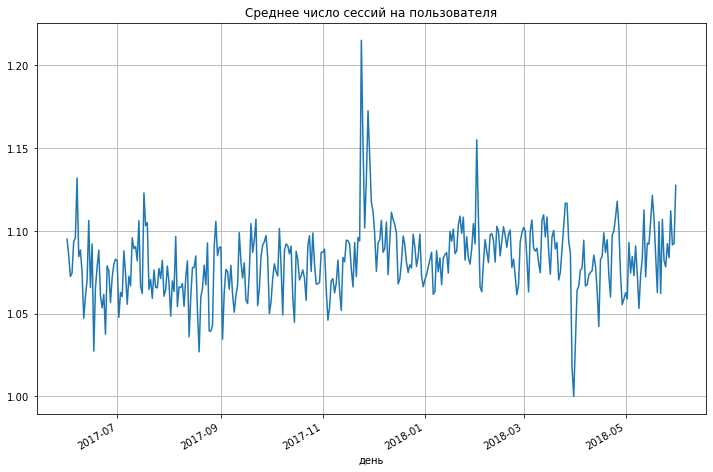

In [21]:
session_per_user.plot(x = 'ts_date', y = 'ses_per_user', figsize = (12,8))
plt.title('Среднее число сессий на пользователя')
plt.xlabel('день')
plt.legend().remove()
plt.grid()
plt.show()

count    364.000000
mean       1.082003
std        0.021399
min        1.000000
25%        1.068140
50%        1.082189
75%        1.094089
max        1.215210
Name: ses_per_user, dtype: float64

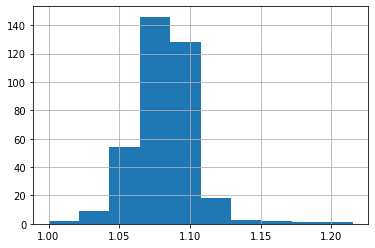

In [22]:
session_per_user['ses_per_user'].hist()
session_per_user['ses_per_user'].describe()

Можем наблюдать, что среднее число сессий на клиента в день почти не меняется, можем отметить только небольшой скачек к новому году. В целом, это логично, ведь расписание многих мероприятий меняется редко, достаточно и одно раза его изучить, чтобы составить планы на вечер. Ряд распределен нормально, средний показатель - 1,1.

#### Оценка одной сессии

Исследуем продолжительность типичной пользовательской сессии. Стоит отметить, ранее, при проверке исходных данных были убраны строки, где продолжительность меньше 0 включительно.

In [23]:
visits_corr['session_duration_sec'] = (visits_corr['end_ts'] - visits_corr['start_ts']).dt.seconds
visits_corr['session_duration_sec'].describe()

<ipython-input-23-72aafbc82239>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visits_corr['session_duration_sec'] = (visits_corr['end_ts'] - visits_corr['start_ts']).dt.seconds


count    323604.000000
mean        714.169516
std        1026.349417
min          19.000000
25%         120.000000
50%         360.000000
75%         900.000000
max       42660.000000
Name: session_duration_sec, dtype: float64

Видим, что средняя в два раза больше медианы, следовательно у данных имеется сильный перекос в право. Попробуем взглянуть на распределение и найти моду.

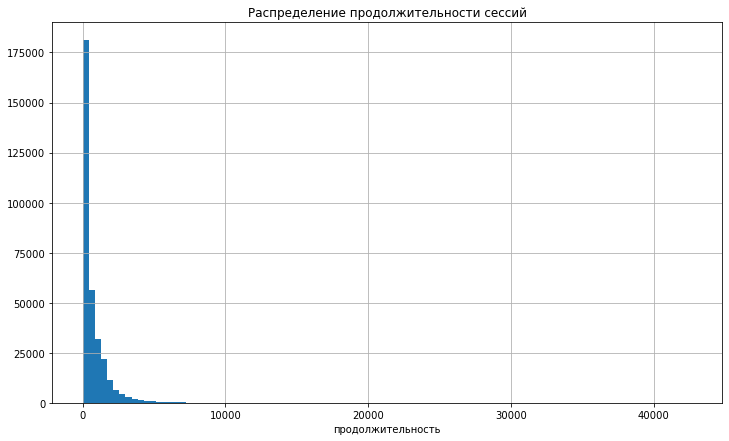

In [24]:
visits_corr['session_duration_sec'].hist(bins = 100, figsize = (12, 7))
plt.title('Распределение продолжительности сессий')
plt.xlabel('продолжительность')
plt.show()

Видим, что при длительности сессии более 1000 секунд растет огромный хвост минимума значений. Давайте отбросим их.

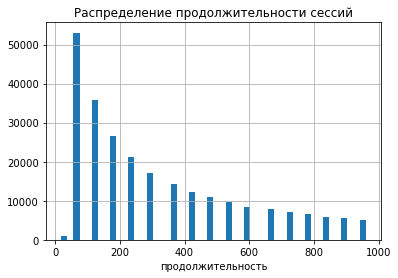

count    248121.000000
mean        316.409462
std         255.932740
min          19.000000
25%         120.000000
50%         240.000000
75%         480.000000
max         960.000000
Name: session_duration_sec, dtype: float64

In [25]:
visits_corr[visits_corr['session_duration_sec'] < 1000]['session_duration_sec'].hist(bins = 50)
plt.title('Распределение продолжительности сессий')
plt.xlabel('продолжительность')
plt.show()
visits_corr[visits_corr['session_duration_sec'] < 1000]['session_duration_sec'].describe()

Медиана и средняя близки друг другу относительно выбокри, можно утверждать, что в основном люди тратят на одну сессию до 5 минут.

####  Retention Rate

 Рассчитайте Retention Rate, применяя когортный анализ. Покажите изменения метрики во времени на графике. Найдите средний Retention Rate на второй месяц «жизни» когорт.

Следующим шагом узнаем, как меняется число пользователей со временем. Для этого проведем когортный анализ и рассчитаем коэффициент удержания.

In [26]:
first_ts_dates = visits_corr.groupby('uid')['ts_date'].min()
first_ts_dates.name = 'first_ts_date'
visits_corr = visits_corr.join(first_ts_dates, on='uid')
visits_corr['first_ts_month'] = visits_corr['first_ts_date'].astype('datetime64[M]')
visits_corr['cohort_lifetime'] = ((visits_corr['month_date'] - visits_corr['first_ts_month']) 
/ np.timedelta64(1, 'M')).round().astype('int')



все необходимые данные получены, когорты соответствуют столбцу first_ts_month. Рассчитаем  Retention rate.

In [27]:
cohorts = visits_corr.groupby(['first_ts_month', 'cohort_lifetime']).agg({'uid' : 'nunique'}).reset_index()
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_ts_month', 'uid']]
initial_users_count = initial_users_count.rename(columns = {'uid' : 'cohort_users'})
cohorts = cohorts.merge(initial_users_count, on = 'first_ts_month')
cohorts['retention'] = cohorts['uid'] / cohorts['cohort_users']
cohorts['first_ts_month'] = cohorts['first_ts_month'].dt.strftime('%Y-%m') 
retention_pivot = cohorts.pivot_table(index = 'first_ts_month', columns = 'cohort_lifetime', values = 'retention', aggfunc = 'sum')
retention_pivot.fillna(' ')

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_ts_month,,,,,,,,,,,,
2017-06,1.0,0.075726,0.050989,0.059739,0.065377,0.06748,0.05772,0.056121,0.050989,0.049727,0.038115,0.043921
2017-07,1.0,0.054545,0.050402,0.055645,0.05666,0.046512,0.044059,0.044059,0.037886,0.027315,0.027061,
2017-08,1.0,0.074452,0.060451,0.060451,0.04797,0.041459,0.036249,0.03766,0.027133,0.024745,,
2017-09,1.0,0.08357,0.067769,0.049322,0.038083,0.036959,0.035372,0.022876,0.022744,,,
2017-10,1.0,0.078129,0.050811,0.037811,0.033648,0.031184,0.020775,0.019798,,,,
2017-11,1.0,0.078183,0.042733,0.037824,0.032593,0.021729,0.020602,,,,,
2017-12,1.0,0.054668,0.036518,0.030178,0.019453,0.017716,,,,,,
2018-01,1.0,0.057794,0.037817,0.024352,0.019249,,,,,,,
2018-02,1.0,0.056561,0.02429,0.019184,,,,,,,,


Готово. Видим, уже со 2 месяца на 94 процента падает количество "вернувшихся" пользователей. Для более наглядного представления построим тепловую карту.

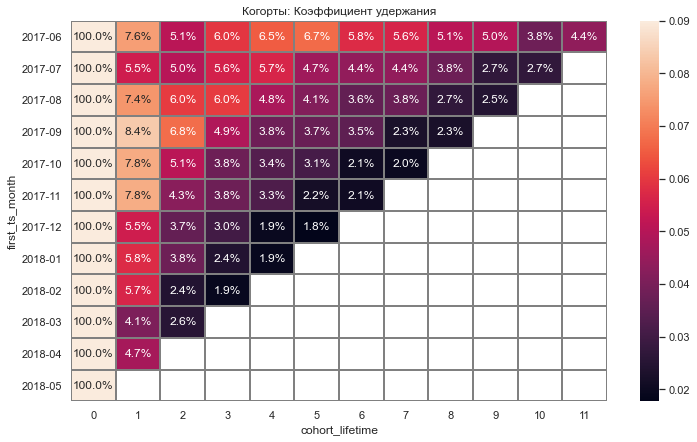

In [28]:
sns.set(style='whitegrid')
plt.figure(figsize=(12, 7))
plt.title('Когорты: Коэффициент удержания')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', vmax = 0.09); 

По тепловой карте делаем вывод, число пользователей после оттока на 2 месяц в 94%, далее почти не меняется. Остаются только энтузиасты - 4 - 6% изначальной аудитории.
Теперь найдем среднее значение коэффициента для 2 месяца жизни когорт.

In [29]:
print('Среднее retention для 2 месяца:', (cohorts[cohorts['cohort_lifetime'] == 1]['retention'].mean()) * 100, '%')

Среднее retention для 2 месяца: 6.380662111395065 %


### Метрики электронной коммерции


#### Время до покупки

Рассчитаем среднее время с момента посещения до совершения покупки. Для этого добавим к таблице Orders столбец времени первого посещения и время первой покупки.

In [30]:
first_ts_time = visits_corr.groupby('uid')['start_ts'].min()
first_ts_time.name = 'first_ts_time'


first_buy_time = orders.groupby('uid')[['buy_ts']].min()
first_buy_time.columns = ['first_buy_time']

AVG_purch_time = first_buy_time.join(first_ts_time, on = 'uid', how = 'inner')

AVG_purch_time['time_per_purchase'] = AVG_purch_time['first_buy_time'] - AVG_purch_time['first_ts_time']
AVG_purch_time['time_per_purchase'].describe()

count                         36081
mean     15 days 10:43:00.661844184
std      45 days 17:18:53.051230094
min             -328 days +03:44:00
25%                 0 days 00:03:00
50%                 0 days 00:15:00
75%                 1 days 05:07:00
max               363 days 07:04:00
Name: time_per_purchase, dtype: object

Получили столбец времени до первой покупки. Видим, что имеются отрицательные значения, чего быть не должно.

In [31]:
AVG_purch_time = AVG_purch_time[AVG_purch_time['time_per_purchase'] > '0 seconds']
AVG_purch_time['time_per_purchase'].describe()

count                         33568
mean     16 days 19:55:46.823164919
std      46 days 18:52:45.702513445
min                 0 days 00:01:00
25%                 0 days 00:05:00
50%                 0 days 00:19:00
75%                 2 days 02:29:15
max               363 days 07:04:00
Name: time_per_purchase, dtype: object

Средняя сильно отличается от медианы, попробуем оценить распределение. Для этой цели представим данные в минутах.

In [32]:
AVG_purch_time['time_per_purchase'] = AVG_purch_time['time_per_purchase'] / np.timedelta64(1, 'm')


Так как 75% покупок совершаются до 2 дней, предлагаю отбросить длинный хвост до 363 дней, и оценить результат

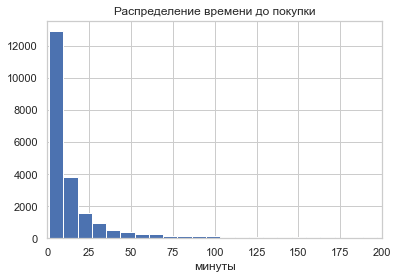

In [33]:
AVG_purch_time[AVG_purch_time['time_per_purchase'] < 600]['time_per_purchase'].hist(bins = 70)
plt.title('Распределение времени до покупки')
plt.xlabel('минуты')
plt.xlim([0, 200])
plt.show()

In [34]:
AVG_purch_time[AVG_purch_time['time_per_purchase'] < 600]['time_per_purchase'].describe()

count    22875.000000
mean        29.762055
std         71.532724
min          1.000000
25%          3.000000
50%          8.000000
75%         20.000000
max        598.000000
Name: time_per_purchase, dtype: float64

In [35]:
AVG_purch_time[AVG_purch_time['time_per_purchase'] < 1450]['time_per_purchase'].mode()

0    1.0
dtype: float64

Можно сделать вывод, что основные значения сконцентрированы до 10 минут, а наиболее частым т минимальным временем выбора выступает 1 минута.

#### Количество покупок 

Не лишним будет понять, сколько покупок совершают клиенты, как часто они возвращаются к услугам Яндекс.Афиша. Построим временное распределение данных по когортам. 
Столбец с временем первой покупки мы уже находили ранее.

In [36]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   buy_ts   50415 non-null  datetime64[ns]
 1   revenue  50415 non-null  float64       
 2   uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


In [37]:
orders = orders.join(first_buy_time, on = 'uid')
orders['first_buy_month'] = orders['first_buy_time'].astype('datetime64[M]')
orders['buy_month'] = orders['buy_ts'].astype('datetime64[M]')
orders['cohort_lifetime'] = ((orders['buy_month'] - orders['first_buy_month']) / np.timedelta64(1, 'M')).round().astype('int')


In [38]:
cohorts_number_orders = orders.groupby(['first_buy_month', 'cohort_lifetime']).agg({'revenue': 'count','uid' : 'nunique'}).reset_index()
cohorts_number_orders = cohorts_number_orders.rename(columns = {'revenue' : 'total_purch', 'uid' : 'uniq_buyers' })
cohorts_number_orders['avg_purches'] = (cohorts_number_orders['total_purch'] / cohorts_number_orders['uniq_buyers']).round(2)
cohorts_number_orders

,first_buy_month,cohort_lifetime,total_purch,uniq_buyers,avg_purches
0,2017-06-01,0,2354,2023,1.16
1,2017-06-01,1,177,61,2.90
2,2017-06-01,2,174,50,3.48
3,2017-06-01,3,226,54,4.19
4,2017-06-01,4,292,88,3.32
...,...,...,...,...,...
74,2018-03-01,2,176,58,3.03
75,2018-04-01,0,2495,2276,1.10
76,2018-04-01,1,195,69,2.83
77,2018-05-01,0,3249,2988,1.09


необходимые данные получены. Подготовим таблицу когорт во времени.

In [39]:
cohorts_number_orders_pivot = cohorts_number_orders.pivot_table(index = 'first_buy_month', columns = 'cohort_lifetime', values = 'avg_purches', aggfunc = 'mean')
cohorts_number_orders_pivot.fillna('')

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_month,,,,,,,,,,,,
2017-06-01,1.16,2.9,3.48,4.19,3.32,3.25,4.45,3.7,3.66,3.4,2.13,1.62
2017-07-01,1.14,1.92,2.11,1.62,1.47,2.16,1.69,1.28,1.38,1.09,2.04,
2017-08-01,1.12,1.86,1.89,1.84,2.12,1.94,1.63,1.77,2.42,1.48,,
2017-09-01,1.14,1.68,1.61,2.22,1.29,1.7,1.64,1.51,1.42,,,
2017-10-01,1.14,1.52,1.32,1.33,1.39,1.43,1.54,1.87,,,,
2017-11-01,1.18,1.79,1.52,1.99,1.68,1.23,1.65,,,,,
2017-12-01,1.15,1.85,1.96,1.85,1.72,1.67,,,,,,
2018-01-01,1.12,1.96,1.92,1.49,1.73,,,,,,,
2018-02-01,1.12,1.88,1.43,1.79,,,,,,,,


найдем среднее количество заказов для 6 месяцев.

In [40]:
cohorts_number_orders_pivot[cohorts_number_orders_pivot.index < '2018-01-01'].loc[:, '0': '5'].mean(axis=1)

first_buy_month
2017-06-01    3.050000
2017-07-01    1.736667
2017-08-01    1.795000
2017-09-01    1.606667
2017-10-01    1.355000
2017-11-01    1.565000
2017-12-01    1.700000
dtype: float64

Таким образом, за 6 месяцев клиенты приобретают в среднем 1.91 товаров в месяц.

#### Средний чек

Давайте теперь оценим размер среднего чека, посмотрим как он изменяется во времени.

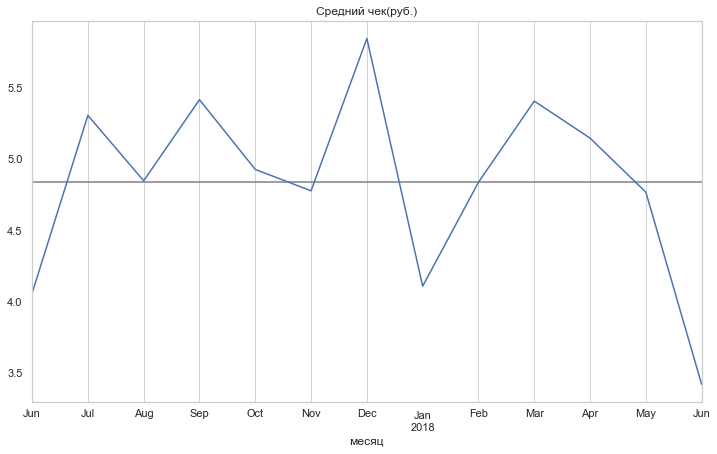

<ipython-input-41-14f47b3182f3>:10: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  avg_order.mean()


revenue    4.838462
dtype: float64

In [41]:
avg_order = orders.groupby(['buy_month'])['revenue'].mean().round(2).reset_index()
avg_order.plot(y = 'revenue', x = 'buy_month', figsize = (12,7))
plt.title('Средний чек(руб.)')
plt.xlabel('месяц')
plt.legend().remove()
plt.grid(which='major', color = 'lightgray', linewidth = 1)
plt.grid(which='minor', color = 'lightgray', linewidth = 1) 
plt.hlines(y = 4.838462, xmin = '2017-06-01', xmax = '2018-06-01', color = 'gray')
plt.show()
avg_order.mean()

Из графика видно, что сумма покупок падает в январе, что понятно, так как все истратили в декабре на подарки, и к лету. Также активность покупок снижается в сезон отпусков. При этом средний чек составляет 4,84

#### LTV

Рассчитаем, как меняется LTV на покупателя по когортам. Для этого к имеющимся данным необходимо посчитать количество новых клиентов для каждой когорты, и найти валовую прибыль.

In [42]:
first_buy_time['first_buy_month'] = first_buy_time['first_buy_time'].astype('datetime64[M]')
first_buy_time = first_buy_time.reset_index()
cohort_sizes = first_buy_time.groupby('first_buy_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_buy_month', 'n_buyers']
cohort_sizes.head()

,first_buy_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340


Просуммируем заказы по когортам.

In [43]:
cohorts_for_LTV = orders.groupby(['first_buy_month', 'cohort_lifetime']).agg({'revenue': 'sum'}).reset_index()
cohorts_for_LTV

,first_buy_month,cohort_lifetime,revenue
0,2017-06-01,0,9557.49
1,2017-06-01,1,981.82
2,2017-06-01,2,885.34
3,2017-06-01,3,1931.30
4,2017-06-01,4,2068.58
...,...,...,...
74,2018-03-01,2,1114.87
75,2018-04-01,0,10600.69
76,2018-04-01,1,1209.92
77,2018-05-01,0,13925.76


Находим Валовую прибыль

In [44]:
report_LTV = cohorts_for_LTV.merge(cohort_sizes, on = 'first_buy_month')
margin_rate = 1
report_LTV['gross_profit'] = report_LTV['revenue'] * margin_rate
report_LTV

,first_buy_month,cohort_lifetime,revenue,n_buyers,gross_profit
0,2017-06-01,0,9557.49,2023,9557.49
1,2017-06-01,1,981.82,2023,981.82
2,2017-06-01,2,885.34,2023,885.34
3,2017-06-01,3,1931.30,2023,1931.30
4,2017-06-01,4,2068.58,2023,2068.58
...,...,...,...,...,...
74,2018-03-01,2,1114.87,3533,1114.87
75,2018-04-01,0,10600.69,2276,10600.69
76,2018-04-01,1,1209.92,2276,1209.92
77,2018-05-01,0,13925.76,2988,13925.76


Считаем метрики

In [45]:
report_LTV['ltv'] = report_LTV['gross_profit'] / report_LTV['n_buyers']

output = report_LTV.pivot_table(index='first_buy_month', columns='cohort_lifetime', values='ltv', aggfunc='mean').cumsum(axis=1).round(2)

output.fillna('') 

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_month,,,,,,,,,,,,
2017-06-01,4.72,5.21,5.65,6.6,7.62,8.36,9.31,9.89,10.45,11.05,11.62,11.88
2017-07-01,6.01,6.35,6.97,7.33,7.5,7.66,7.78,7.92,8.08,8.23,8.39,
2017-08-01,5.28,5.75,6.21,6.6,7.09,7.38,7.59,7.99,8.28,8.47,,
2017-09-01,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.44,,,
2017-10-01,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,,,,
2017-11-01,5.15,5.55,5.75,6.08,6.23,6.28,6.4,,,,,
2017-12-01,4.74,5.0,5.92,6.99,7.3,7.64,,,,,,
2018-01-01,4.14,4.43,4.73,4.88,4.94,,,,,,,
2018-02-01,4.16,4.44,4.51,4.59,,,,,,,,


Найдем средние значения LTV для каждой когорты со 2 месяца

In [46]:
output.loc[:, '1': '5'].mean(axis=1).round(2)

first_buy_month
2017-06-01    6.69
2017-07-01    7.16
2017-08-01    6.61
2017-09-01    9.85
2017-10-01    5.87
2017-11-01    5.98
2017-12-01    6.57
2018-01-01    4.74
2018-02-01    4.51
2018-03-01    5.30
2018-04-01    5.19
2018-05-01     NaN
2018-06-01     NaN
dtype: float64

Для наглядности отобразим результат на графике.

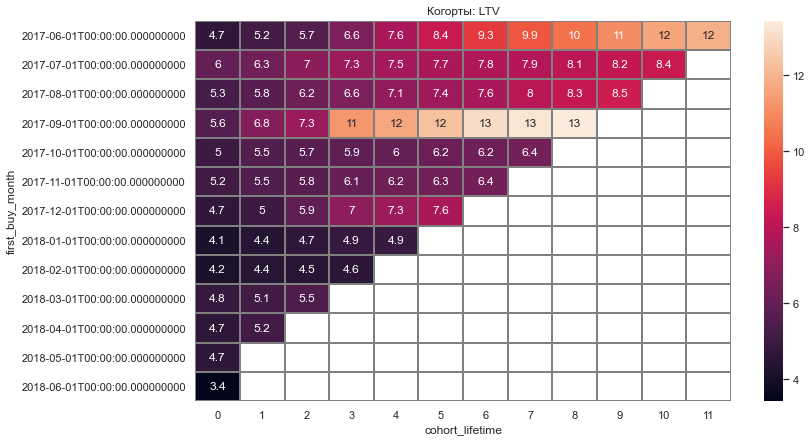

In [47]:
sns.set(style='whitegrid')
plt.figure(figsize=(12, 7))
plt.title('Когорты: LTV')
sns.heatmap(output, annot=True, linewidths=1, linecolor='gray'); 

Прибыль от клиента не велика, исчисляется копейками в месяц. Только в первый месяц совершаются более менее стоящие покупки. Наблюдаем резкий прирост когорты 09-2017 в преддверии нового года.

In [48]:
output[output.index < '2018-01-01'].loc[:, '0': '5'].mean(axis=0).round(2)

cohort_lifetime
0    5.22
1    5.74
2    6.22
3    7.25
4    7.63
5    7.97
dtype: float64

Накопленный LTV по средней когорте, старше 6 месяцев, составляет почти 8 рублей. Наиболее прибыльными представляются первая, 2017-09 и 2017-12 когорты.

### Маркетинговые

#### Расходы на маркетинг

Посмотрим на таблицу расходов.

In [49]:
display(costs.head())
print('Общая сумма расходов:', costs['costs'].sum())

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


Общая сумма расходов: 329131.62


Определим расходы по источникам.

In [50]:
sources_costs = costs.groupby('source_id')['costs'].sum()
sources_costs

source_id
1      20833.27
2      42806.04
3     141321.63
4      61073.60
5      51757.10
9       5517.49
10      5822.49
Name: costs, dtype: float64

Теперь представим, как распределены расходы по месяцам в разрезе видов источников.

In [51]:
costs['month'] = costs['dt'].astype('datetime64[M]')
monthly_costs = costs.groupby(['month', 'source_id' ])['costs'].sum().reset_index()

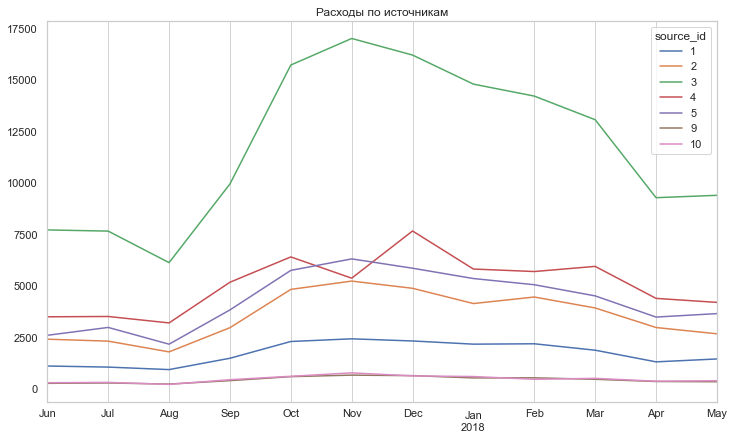

In [52]:
monthly_costs_pivot = monthly_costs.pivot_table(index = 'month', columns = 'source_id', values = 'costs', aggfunc = 'sum')
monthly_costs_pivot.plot(figsize = (12, 7))
plt.title('Расходы по источникам')
plt.xlabel('')
plt.grid(which='major', color = 'lightgray', linewidth = 1)
plt.grid(which='minor', color = 'lightgray', linewidth = 1) 
plt.show()

По графику делаем вывод, что расходы на привлечение в течение года росли в преддверии нового года и далее падали до исходного уровня. Наиболее затратным каналом рекламы является 3 - 43% от общих расходов. 9 и 10 почти бесплатные, лишь 1,8% каждый. Оставшиеся каналы примерно в равных долях финансируются.

Рассчитаем средний CAC для всего проекта. общая сумма расходов имеется, найдем количество уникальных клиентов по видам источников

In [53]:
orders['uid'].nunique()

36523

In [54]:
CAC_total = costs['costs'].sum() / orders['uid'].nunique()
CAC_total.round(2)

9.01

Средний расход на привлечение одного клиента составил 9 рублей. Теперь узнаем расходы на привлечение по видам источников.

Первым шагом определим для каждого клиента источник.

In [55]:
user_per_source = visits.groupby(['uid'])['source_id'].first()
orders = orders.merge(user_per_source, how = 'left', on = 'uid' )
orders

,buy_ts,revenue,uid,first_buy_time,first_buy_month,buy_month,cohort_lifetime,source_id
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01,0,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01,0,2
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01,0,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01,0,2
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01,0,3
...,...,...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31 23:50:00,2018-05-01,2018-05-01,0,4
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31 23:50:00,2018-05-01,2018-05-01,0,10
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31 23:54:00,2018-05-01,2018-05-01,0,3
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-31 23:56:00,2018-05-01,2018-05-01,0,4


Сгруппируем поученные данные по источникам, получим число уникальных пользователей по каждому виду и месяцу.

In [56]:
users_in_sources = orders.groupby(['source_id', 'first_buy_month'])['uid'].nunique().reset_index()
users_in_sources

,source_id,first_buy_month,uid
0,1,2017-06-01,203
1,1,2017-07-01,211
2,1,2017-08-01,145
3,1,2017-09-01,283
4,1,2017-10-01,409
...,...,...,...
81,10,2018-01-01,87
82,10,2018-02-01,126
83,10,2018-03-01,178
84,10,2018-04-01,112


Используя разбивку расходов по месяцам и источникам, соединим таблицы и вычислим САС.

In [57]:
monthly_costs = monthly_costs.merge(users_in_sources, left_on = ['month','source_id'] , right_on = ['first_buy_month','source_id'], how = 'left')
monthly_costs['CAC'] = monthly_costs['costs'] / monthly_costs['uid']
monthly_cac_pivot = monthly_costs.pivot_table(index = 'first_buy_month', columns = 'source_id', values = 'CAC', aggfunc = 'sum')

In [58]:
monthly_cac_pivot

source_id,1,2,3,4,5,9,10
first_buy_month,,,,,,,
2017-06-01,5.544877,8.957122,13.469774,8.428777,7.109022,2.769126,3.611724
2017-07-01,5.084739,9.078249,17.323634,7.233053,7.439553,4.033867,7.170000
2017-08-01,6.564207,11.836928,21.184621,9.779210,6.602054,2.963452,6.285676
2017-09-01,5.307456,9.600193,15.399614,8.906106,6.579726,3.996346,6.774559
2017-10-01,5.661980,9.728916,15.219768,5.805461,6.214871,3.502356,3.283979
2017-11-01,5.409646,10.169922,16.545520,4.790062,9.627610,3.614709,7.012035
2017-12-01,5.111790,9.584736,14.202732,5.958472,7.946576,3.987758,8.175443
2018-01-01,6.487181,12.121691,17.483802,5.832790,8.302195,4.885357,7.061494
2018-02-01,6.389797,11.805646,14.638436,5.486993,7.546592,4.754310,3.816508


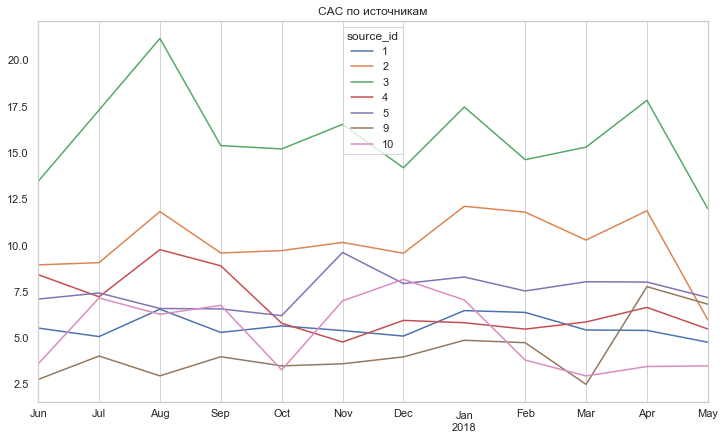

In [59]:
monthly_cac_pivot.plot(figsize = (12, 7))
plt.title('CAC по источникам')
plt.xlabel('')
plt.grid(which='major', color = 'lightgray', linewidth = 1)
plt.grid(which='minor', color = 'lightgray', linewidth = 1) 
plt.show()

По графикам можно видеть, что самое дорогое привлечение обошлось по 3 источнику, в среднем 16 у.е. на клиента. На остальные каналы приходится от 6 до 10 у.е. САС

#### ROMI

Рассчитаем ROMI по когортам в разрезе источников.

In [60]:
orders

,buy_ts,revenue,uid,first_buy_time,first_buy_month,buy_month,cohort_lifetime,source_id
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01,0,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01,0,2
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01,0,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01,0,2
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01,0,3
...,...,...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31 23:50:00,2018-05-01,2018-05-01,0,4
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31 23:50:00,2018-05-01,2018-05-01,0,10
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31 23:54:00,2018-05-01,2018-05-01,0,3
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-31 23:56:00,2018-05-01,2018-05-01,0,4


Для построения когорт по видам источников введем функцию, с описанием всех процессов.

In [61]:
costs_per_month = costs.groupby('month')['costs'].sum().reset_index()
margin_rate = 1

In [62]:
def romi_per_source(i):
    romicohorts_per_source = orders[orders['source_id'] == i].groupby(['first_buy_month', 'cohort_lifetime']).agg({'revenue': 'sum'}).reset_index()
    n_buyers_source = orders[orders['source_id'] == i].groupby('first_buy_month')['uid'].nunique()
    n_buyers_source.name = 'n_buyers'
    romicohorts_per_source = romicohorts_per_source.join(n_buyers_source, on = 'first_buy_month')

    romicohorts_per_source['gross_profit'] = romicohorts_per_source['revenue'] * margin_rate
    romicohorts_per_source['LTV'] = (romicohorts_per_source['gross_profit'] / romicohorts_per_source['n_buyers'])
    
    romicohorts_per_source = romicohorts_per_source.merge(monthly_cac_pivot[i], on = 'first_buy_month', how = 'left')
    romicohorts_per_source = romicohorts_per_source.rename(columns = {i : 'CAC'})
    romicohorts_per_source['ROMI'] = (romicohorts_per_source['LTV'] / romicohorts_per_source['CAC'])
        
    romi_pivot_per_source = romicohorts_per_source.pivot_table(index = 'first_buy_month', columns = 'cohort_lifetime', values = 'ROMI', aggfunc = 'mean')
    ltv_pivot_per_source = romicohorts_per_source.pivot_table(index = 'first_buy_month', columns = 'cohort_lifetime', values = 'LTV', aggfunc = 'mean')
    
    print('Когорты LTV по источнику {}'.format(i))
    display(ltv_pivot_per_source.sum(axis = 1))
    print('LTV:', romicohorts_per_source['LTV'].sum().round(2))
    print()
    print('Когорты lifetime ROMI по источнику {}'.format(i))
    display(romi_pivot_per_source.cumsum(axis=1).round(4).fillna(''))
    print('Средняя Когорта ROMI по источнику {}'.format(i))
    print(romi_pivot_per_source.cumsum(axis=1).mean(axis=0))
    print('-----------------------------------------------------------')

Теперь поочередно посчитаем все источники.

In [63]:
romi_per_source(1)
romi_per_source(2)
romi_per_source(3)
romi_per_source(4)
romi_per_source(5)
romi_per_source(9)
romi_per_source(10)

Когорты LTV по источнику 1


first_buy_month
2017-06-01    34.592365
2017-07-01    17.304692
2017-08-01     8.827172
2017-09-01    15.823710
2017-10-01     8.799438
2017-11-01     7.550553
2017-12-01     5.457183
2018-01-01     8.604421
2018-02-01     6.806319
2018-03-01    10.795144
2018-04-01     7.955918
2018-05-01     5.418502
dtype: float64

LTV: 137.94

Когорты lifetime ROMI по источнику 1


cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_month,,,,,,,,,,,,
2017-06-01,1.0381,1.3605,1.4971,2.1153,2.7911,3.426,4.2901,4.6435,5.042,5.6021,6.1403,6.2386
2017-07-01,1.5119,1.7077,2.4854,2.715,2.7906,2.9335,3.0065,3.105,3.1828,3.2628,3.4033,
2017-08-01,0.9329,0.9877,1.0121,1.0767,1.1179,1.136,1.2144,1.2785,1.3041,1.3447,,
2017-09-01,1.4298,1.6003,1.8598,2.1052,2.2216,2.2703,2.7271,2.8777,2.9814,,,
2017-10-01,1.0735,1.2651,1.3685,1.4276,1.4583,1.4744,1.5069,1.5541,,,,
2017-11-01,1.0717,1.1558,1.2838,1.3515,1.3756,1.3815,1.3958,,,,,
2017-12-01,0.8699,0.91,0.9702,1.0145,1.0416,1.0676,,,,,,
2018-01-01,0.9380,1.1327,1.1762,1.3001,1.3264,,,,,,,
2018-02-01,0.7849,0.9778,1.0049,1.0652,,,,,,,,


Средняя Когорта ROMI по источнику 1
cohort_lifetime
0     1.101002
1     1.305029
2     1.464239
3     1.574571
4     1.765376
5     1.955612
6     2.356804
7     2.691766
8     3.127567
9     3.403211
10    4.771783
11    6.238617
dtype: float64
-----------------------------------------------------------
Когорты LTV по источнику 2


first_buy_month
2017-06-01    23.166494
2017-07-01    10.507198
2017-08-01     8.470392
2017-09-01    60.886270
2017-10-01    11.681205
2017-11-01     8.865678
2017-12-01    28.810783
2018-01-01     5.722332
2018-02-01     5.015435
2018-03-01     6.587467
2018-04-01     6.224167
2018-05-01     6.398330
dtype: float64

LTV: 182.34

Когорты lifetime ROMI по источнику 2


cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_month,,,,,,,,,,,,
2017-06-01,0.6393,0.7547,0.8555,1.1651,1.4829,1.6667,1.9201,2.1417,2.2672,2.3906,2.4743,2.5864
2017-07-01,0.7844,0.857,0.8897,0.9671,1.0071,1.0233,1.0478,1.0647,1.091,1.1116,1.1574,
2017-08-01,0.4840,0.5591,0.6054,0.6118,0.6432,0.658,0.6626,0.6824,0.7069,0.7156,,
2017-09-01,0.9107,1.6404,1.8965,5.1386,5.4007,5.8519,6.1508,6.262,6.3422,,,
2017-10-01,0.7692,1.0114,1.0455,1.094,1.1241,1.1741,1.1828,1.2007,,,,
2017-11-01,0.6231,0.7139,0.7528,0.8183,0.8409,0.8556,0.8718,,,,,
2017-12-01,0.7659,0.9062,1.6413,2.5173,2.7534,3.0059,,,,,,
2018-01-01,0.3611,0.3826,0.4496,0.4631,0.4721,,,,,,,
2018-02-01,0.3835,0.4084,0.4192,0.4248,,,,,,,,


Средняя Когорта ROMI по источнику 2
cohort_lifetime
0     0.652748
1     0.758661
2     0.919535
3     1.466676
4     1.715544
5     2.033639
6     1.972646
7     2.270282
8     2.601835
9     1.405951
10    1.815830
11    2.586377
dtype: float64
-----------------------------------------------------------
Когорты LTV по источнику 3


first_buy_month
2017-06-01    5.312596
2017-07-01    5.829097
2017-08-01    6.328690
2017-09-01    5.446414
2017-10-01    5.021557
2017-11-01    5.942420
2017-12-01    4.646375
2018-01-01    4.258170
2018-02-01    4.190998
2018-03-01    4.554461
2018-04-01    4.132687
2018-05-01    3.809745
dtype: float64

LTV: 59.47

Когорты lifetime ROMI по источнику 3


cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_month,,,,,,,,,,,,
2017-06-01,0.3190,0.3291,0.3346,0.3479,0.3673,0.3736,0.3766,0.3803,0.3846,0.3867,0.3901,0.3944
2017-07-01,0.3000,0.309,0.3104,0.318,0.3189,0.3223,0.3247,0.3278,0.3292,0.3341,0.3365,
2017-08-01,0.2604,0.2657,0.2746,0.28,0.2877,0.2882,0.2907,0.2948,0.2954,0.2987,,
2017-09-01,0.3248,0.3304,0.3384,0.34,0.3421,0.3446,0.3502,0.3522,0.3537,,,
2017-10-01,0.2868,0.3029,0.3089,0.3148,0.3234,0.3258,0.3269,0.3299,,,,
2017-11-01,0.2908,0.3156,0.3227,0.3387,0.3417,0.3435,0.3592,,,,,
2017-12-01,0.3040,0.3084,0.3138,0.3204,0.3241,0.3271,,,,,,
2018-01-01,0.2285,0.2331,0.2394,0.2427,0.2435,,,,,,,
2018-02-01,0.2647,0.2825,0.2854,0.2863,,,,,,,,


Средняя Когорта ROMI по источнику 3
cohort_lifetime
0     0.283503
1     0.291111
2     0.302557
3     0.309855
4     0.318609
5     0.332169
6     0.338037
7     0.336997
8     0.340694
9     0.339839
10    0.363272
11    0.394409
dtype: float64
-----------------------------------------------------------
Когорты LTV по источнику 4


first_buy_month
2017-06-01    7.017746
2017-07-01    7.855492
2017-08-01    7.438875
2017-09-01    6.393825
2017-10-01    5.236293
2017-11-01    6.438107
2017-12-01    4.538580
2018-01-01    4.030060
2018-02-01    4.313151
2018-03-01    4.957970
2018-04-01    5.269486
2018-05-01    4.714772
2018-06-01    3.420000
dtype: float64

LTV: 71.62

Когорты lifetime ROMI по источнику 4


cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_month,,,,,,,,,,,,
2017-06-01,0.5803,0.5923,0.6023,0.6268,0.6468,0.6669,0.6941,0.7075,0.7298,0.754,0.8168,0.8326
2017-07-01,0.8823,0.8923,0.9222,0.9603,0.9828,0.9925,1.0073,1.0228,1.0597,1.0833,1.0861,
2017-08-01,0.5060,0.528,0.5474,0.5869,0.62,0.6461,0.6544,0.7381,0.7522,0.7607,,
2017-09-01,0.5774,0.6222,0.6315,0.6382,0.6442,0.6813,0.7049,0.7114,0.7179,,,
2017-10-01,0.7560,0.7932,0.8232,0.8389,0.8656,0.8768,0.8874,0.902,,,,
2017-11-01,1.0968,1.1809,1.1998,1.2788,1.3281,1.3358,1.3441,,,,,
2017-12-01,0.6964,0.7146,0.7298,0.7407,0.7493,0.7617,,,,,,
2018-01-01,0.6530,0.673,0.6814,0.6873,0.6909,,,,,,,
2018-02-01,0.7558,0.777,0.7821,0.7861,,,,,,,,


Средняя Когорта ROMI по источнику 4
cohort_lifetime
0     0.740604
1     0.758851
2     0.776367
3     0.793777
4     0.815964
5     0.851594
6     0.882016
7     0.816357
8     0.814887
9     0.865984
10    0.951410
11    0.832594
dtype: float64
-----------------------------------------------------------
Когорты LTV по источнику 5


first_buy_month
2017-06-01    11.117636
2017-07-01     6.434789
2017-08-01    10.575680
2017-09-01     5.609624
2017-10-01     6.254569
2017-11-01     4.993166
2017-12-01     5.482571
2018-01-01     5.362442
2018-02-01     4.651399
2018-03-01     5.230320
2018-04-01     4.843349
2018-05-01     4.124000
dtype: float64

LTV: 74.68

Когорты lifetime ROMI по источнику 5


cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_month,,,,,,,,,,,,
2017-06-01,0.6833,0.755,0.909,1.0163,1.1333,1.2055,1.2861,1.3482,1.4395,1.51,1.5461,1.5639
2017-07-01,0.7070,0.7509,0.7942,0.8086,0.8198,0.8343,0.8365,0.8493,0.8529,0.8621,0.8649,
2017-08-01,0.7597,0.8834,1.0318,1.149,1.326,1.4277,1.492,1.5294,1.5683,1.6019,,
2017-09-01,0.7567,0.7796,0.7857,0.8204,0.8241,0.8319,0.8438,0.8461,0.8526,,,
2017-10-01,0.8531,0.8787,0.8981,0.9135,0.9331,0.9529,0.9802,1.0064,,,,
2017-11-01,0.4732,0.4776,0.4857,0.4958,0.5099,0.5163,0.5186,,,,,
2017-12-01,0.6481,0.6635,0.6769,0.6822,0.6852,0.6899,,,,,,
2018-01-01,0.4811,0.5329,0.6197,0.6315,0.6459,,,,,,,
2018-02-01,0.5689,0.5851,0.6015,0.6164,,,,,,,,


Средняя Когорта ROMI по источнику 5
cohort_lifetime
0     0.639231
1     0.685082
2     0.745261
3     0.792617
4     0.859646
5     0.922636
6     0.992885
7     1.115891
8     1.178304
9     1.324652
10    1.205507
11    1.563877
dtype: float64
-----------------------------------------------------------
Когорты LTV по источнику 9


first_buy_month
2017-06-01     4.445631
2017-07-01     8.170267
2017-08-01    12.433690
2017-09-01     5.099135
2017-10-01     4.981839
2017-11-01     4.926190
2017-12-01     4.618424
2018-01-01     3.777321
2018-02-01     4.024310
2018-03-01     2.797865
2018-04-01     5.087292
2018-05-01     3.780755
dtype: float64

LTV: 64.14

Когорты lifetime ROMI по источнику 9


cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10
first_buy_month,,,,,,,,,,,
2017-06-01,1.2279,1.2979,1.3217,1.3723,1.4051,1.4702,1.49,1.4994,1.5512,1.5861,1.6054
2017-07-01,1.3855,1.4768,1.6169,1.6989,1.8491,1.8654,1.926,1.9624,2.0077,,2.0254
2017-08-01,1.6230,1.9471,2.2192,2.406,2.5662,2.707,2.7817,3.0726,3.868,4.1957,
2017-09-01,0.9620,1.123,1.2049,1.2325,1.2554,,1.273,,1.2759,,
2017-10-01,1.1810,1.2694,1.3005,1.34,1.3632,1.3955,1.4012,1.4224,,,
2017-11-01,1.1606,1.2176,1.246,1.3068,1.3154,1.3379,1.3628,,,,
2017-12-01,0.9212,1.0103,1.0577,1.1377,1.149,1.1582,,,,,
2018-01-01,0.6408,0.6687,0.749,0.7644,0.7732,,,,,,
2018-02-01,0.7961,0.8267,0.8434,0.8465,,,,,,,


Средняя Когорта ROMI по источнику 9
cohort_lifetime
0     1.013361
1     1.143924
2     1.267759
3     1.345007
4     1.459570
5     1.655701
6     1.705786
7     1.989203
8     2.175699
9     2.890911
10    1.815423
dtype: float64
-----------------------------------------------------------
Когорты LTV по источнику 10


first_buy_month
2017-06-01    2.371264
2017-07-01    3.359130
2017-08-01    5.444324
2017-09-01    2.929559
2017-10-01    2.788115
2017-11-01    4.798850
2017-12-01    3.721392
2018-01-01    3.119425
2018-02-01    2.740238
2018-03-01    3.314551
2018-04-01    2.638393
2018-05-01    4.093419
dtype: float64

LTV: 41.32

Когорты lifetime ROMI по источнику 10


cohort_lifetime,0,1,2,3,4,5,6,7,8,11
first_buy_month,,,,,,,,,,
2017-06-01,0.6143,0.6495,,,0.6507,,,,0.6534,0.6565
2017-07-01,0.4544,0.4593,,0.4685,,,,,,
2017-08-01,0.7357,0.7536,0.8061,,,,0.8264,0.8661,,
2017-09-01,0.3382,0.3503,0.3616,0.3973,0.4,0.4039,0.4071,0.4218,0.4324,
2017-10-01,0.7908,0.813,0.8254,0.8324,0.8432,,0.849,,,
2017-11-01,0.6283,0.6367,0.639,0.6566,0.6748,0.6767,0.6844,,,
2017-12-01,0.4453,,0.4458,,,0.4552,,,,
2018-01-01,0.4395,0.4418,,,,,,,,
2018-02-01,0.6710,0.685,0.718,,,,,,,


Средняя Когорта ROMI по источнику 10
cohort_lifetime
0     0.674280
1     0.665895
2     0.702392
3     0.588721
4     0.642164
5     0.511933
6     0.691714
7     0.643984
8     0.542931
11    0.656546
dtype: float64
-----------------------------------------------------------


## Выводы по метрикам

Для подготовки выводов объединим результаты по ROMI.

,s1,s2,s3,s4,s5,s9,s10
0,1.10,0.65,0.28,0.74,0.64,1.01,0.67
1,1.31,0.76,0.29,0.76,0.69,1.14,0.67
2,1.46,0.92,0.30,0.78,0.75,1.27,0.70
3,1.57,1.47,0.31,0.79,0.79,1.35,0.59
4,1.77,1.72,0.32,0.82,0.86,1.46,0.64
5,1.96,2.03,0.33,0.85,0.92,1.66,0.51
6,2.36,1.97,0.34,0.88,0.99,1.71,0.69
7,2.69,2.27,0.34,0.82,1.12,1.99,0.64
8,3.13,2.60,0.34,0.81,1.18,2.18,0.54
9,3.40,1.41,0.34,0.87,1.32,2.89,0.66


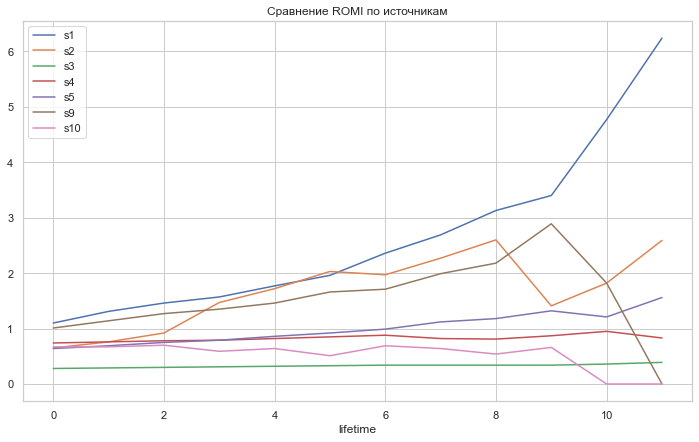

In [64]:
data = {'s1' : ['1.101002',
     '1.305029',
     '1.464239',
     '1.574571',
     '1.765376',
     '1.955612',
     '2.356804',
     '2.691766',
     '3.127567',
     '3.403211',
    '4.771783',
    '6.238617' ],

's2' : ['0.652748',
     '0.758661',
     '0.919535',
     '1.466676',
     '1.715544',
     '2.033639',
     '1.972646',
     '2.270282',
     '2.601835',
     '1.405951',
    '1.815830',
    '2.586377'],

's3' : ['0.283503',
     '0.291111',
     '0.302557',
     '0.309855',
     '0.318609',
     '0.332169',
     '0.338037',
     '0.336997',
     '0.340694',
     '0.339839',
    '0.363272',
    '0.394409'],

's4' : ['0.740604',
     '0.758851',
     '0.776367',
     '0.793777',
     '0.815964',
     '0.851594',
     '0.882016',
     '0.816357',
     '0.814887',
     '0.865984',
    '0.951410',
    '0.832594'],

's5' : ['0.639231',
     '0.685082',
     '0.745261',
     '0.792617',
     '0.859646',
     '0.922636',
     '0.992885',
     '1.115891',
     '1.178304',
     '1.324652',
    '1.205507',
    '1.563877'],

's9' : ['1.013361',
     '1.143924',
     '1.267759',
     '1.345007',
     '1.459570',
     '1.655701',
     '1.705786',
     '1.989203',
     '2.175699',
     '2.890911',
    '1.815423',
       '0'],

's10' : ['0.674280',
     '0.665895',
     '0.702392',
     '0.588721',
     '0.642164',
     '0.511933',
     '0.691714',
     '0.643984',
     '0.542931',
    '0.656546',
        '0',
        '0']}

comparison = pd.DataFrame(data)
comparison['s1'] = comparison['s1'].astype('float64').round(2)
comparison['s2'] = comparison['s2'].astype('float64').round(2)
comparison['s3'] = comparison['s3'].astype('float64').round(2)
comparison['s4'] = comparison['s4'].astype('float64').round(2)
comparison['s5'] = comparison['s5'].astype('float64').round(2)
comparison['s9'] = comparison['s9'].astype('float64').round(2)
comparison['s10'] = comparison['s10'].astype('float64').round(2)
display(comparison)
comparison.plot(figsize = (12, 7))
plt.title('Cравнение ROMI по источникам')
plt.xlabel('lifetime')
plt.show()

In [65]:
data1 = { 's1' : 137.94, 's2' : 182.34, 's3' : 59.47, 's4' : 71.62, 's5' : 74.68, 's9' : 64.14, 's10' : 41.32}
ltv_per_source_total = pd.DataFrame(data1, index = [0])
ltv_per_source_total

,s1,s2,s3,s4,s5,s9,s10
0,137.94,182.34,59.47,71.62,74.68,64.14,41.32


### Оптимальные источники трафика

По полученным данным о возврате средств на инвестиции делаем вывод, что наиболее выгодными каналами для инвестирования оказались 1 и 2, их результирующий ROMI вышел в 6,24 и 2,59, при этом неплохой LTV 137.94 и 182.34. Можно также взять в работу и 5 канал с результатом 1,56. Неплохие результаты показывала аудитория 9 канала, однако с марта 2018 сильно нарастили маркетинговый бюджет, что пока не принесло результатов. За ними следом с небольшим отрывом 4 канал, но результаты чуть хуже, при высоком LTV затрачены приличные средства на привлечение 61 073, что значительно выше затрат у 1 и 2 каналов.
Если при этом обратить внимание на дороговизну маркетинговых затрат, 1 канал составил 6% от общих трат, 2 канал - 13%. 

От 3 и 10 каналов можно вовсе отказаться.

Для получения результатов были использованы обычная скользящая сумма, когортный анализ для метрик LTV, ROMI. Хоть ROMI и является оптимальной метрикой в нашем случае, так как ее достаточно для определения эффективности канала, тем не менее, важно видеть и сумму абсолютных расходов, сравнивать с прибылью на клиента. Становится ясным, что разные каналы при схожих графиках имеют различное соотношение доходов и затрат. В таком случае, лучше сделать упор на канал с большей прибыльностью клиента, так как при масштабировании такой канал будет активнее прирастать доходностью.

### О чем говорят метрики, маркетинговые, продуктовые и электронной коммерции

В рамках проделанной работы были получены следующе результаты:
- Заметен значительный прирост клиентов к новому году. Новогодние каникулы и сам праздник требуют тщательного планирования с помощью Яндекс.Афиша! В сезон отпусков и загородного отдыха востребованность сервиса снижается.  Майский всплеск характерен для конца учебного года, лишний повод отметить. Ресурс в целом прирастает на 20 955 пользователей в месяц;
- В течение года средний показатель количества сессий в день на клиента - 1,1. Наблюдается рост частоты использования к новому году до 1,2, при этом люди тратят на одну сессию от 19 секунд до 5 минут;
- Retention rate сигнализирует проблему, 94% клиентов по когортам перестают использовать сервис уже со 2 месяца, остаются только энтузиасты - 4 - 6% изначальной аудитории. Почему сервис не мотивирует возвращаться?
- При использовании Афиши на совершение покупки у половины клиентов уходит от 1 до 10 минут;
- Клиенты приобретают в среднем 1.91 товаров в месяц, а средний чек составляет 4,84 у.е.;
- Прибыль от клиента не велика, исчисляется копейками в месяц. Только в первый месяц совершаются более менее стоящие покупки. Накопленный LTV по средней когорте, старше 6 месяцев составляет почти 8 рублей;
- Расходы на привлечение в течение года росли в преддверии нового года и далее падали до исходного уровня. Наиболее затратным каналом рекламы стал 3 - 43% от общих расходов или 16 у.е. на клиента. 9 и 10 почти бесплатные, 1,8% каждый. Оставшиеся 4 канала примерно в равных долях финансируются на 50% от расходов от 6 до 10 у.е. САС.

### Итоги когортного анализа. Перспективные для компании когорты клиентов

Наиболее прибыльными по метрике LTV представляются первая, 2017-09 и 2017-12 когорты. Вывод подкрепляется особенностью пользования сервисом и  сезонностью. Первая когорта стартовала в июне, когда еще не все клиенты разъехались по отпускам, поэтому в первый месяц неплохой результат в 4,7 у.е. Когорта 2017-09 попала в начало активного сезона и сразу 5,6 у.е. Ну коготра 2017-12 вышла на предновогоднем ажиотаже. Хороший старт этих когорт и в последующем обеспечил им чуть более позитивные результаты, так в среднем по времени эти когорты без 1 месяца показали 0,73, 1,33 и 0,58 у.е. месячной прибавки соответственно.
